In [26]:
%matplotlib inline

import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras import Input

import os
import numpy as np
import matplotlib.pyplot as plt

from IPython import display

In [2]:
def Kernel(x, x0):
    sigma = 0.8
    protonFraction = 0.4
    norm = protonFraction/(np.sqrt(2.*np.pi)*sigma)
    return(norm*np.exp(-(x - x0)**2./(2.*sigma**2.)))

def testDataGen():
    A = 197
    yBeam = 5.36
    slope = 0.5
    sigmaEtas = 0.2
    
    # generate input data
    nBaryons = np.random.randint(0, 2*A)
    randX = np.random.uniform(0, 1, size=nBaryons)
    etasBaryon = 1./slope*np.arcsinh((2.*randX - 1)*np.sinh(slope*yBeam))
    etasArr = np.linspace(-6.4, 6.4, 128)
    dNBdetas = np.zeros(len(etasArr))
    norm = 1./(np.sqrt(2.*np.pi)*sigmaEtas)
    for iB in etasBaryon:
        dNBdetas += norm*np.exp(-(etasArr - iB)**2./(2.*sigmaEtas**2.))
    
    # generate test data with convolution with a kernel
    dNpdy = np.zeros(len(etasArr))
    detas = etasArr[1] - etasArr[0]
    for i in range(len(etasArr)):
        dNpdy[i] = sum(Kernel(etasArr, etasArr[i])*dNBdetas)*detas
        
    # generate fake data with random noise
    dNBdetasFake = np.random.uniform(0.0, dNBdetas.max(), size=len(etasArr))
    dNpdyFake = np.random.uniform(0.0, dNpdy.max(), size=len(etasArr))
    return(etasArr, dNBdetas, dNpdy, dNBdetasFake, dNpdyFake)

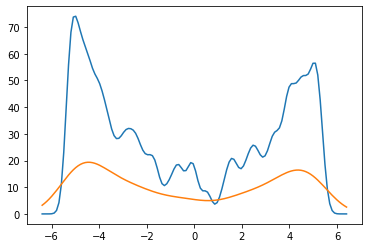

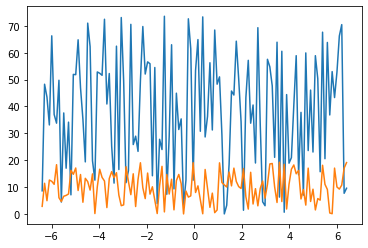

In [3]:
x, y1, y2, y3, y4 = testDataGen()
fig = plt.figure()
plt.plot(x, y1)
plt.plot(x, y2)
fig = plt.figure()
plt.plot(x, y3)
plt.plot(x, y4)

This output is 'normal' ie. Real vs Noise

In [4]:
def FakeKernel(x, x0):
    sigma = 0.5 #Just a slight nudge
    protonFraction = 0.4
    norm = protonFraction/(np.sqrt(2.*np.pi)*sigma)
    return(norm*np.exp(-(x - x0)**2./(2.*sigma**2.)))

def testDataGenFakeKernel():
    A = 197
    yBeam = 5.36
    slope = 0.5
    sigmaEtas = 0.2
    
    # generate input data
    nBaryons = np.random.randint(0, 2*A)
    randX = np.random.uniform(0, 1, size=nBaryons)
    etasBaryon = 1./slope*np.arcsinh((2.*randX - 1)*np.sinh(slope*yBeam))
    etasArr = np.linspace(-6.4, 6.4, 128)
    dNBdetas = np.zeros(len(etasArr))
    norm = 1./(np.sqrt(2.*np.pi)*sigmaEtas)
    for iB in etasBaryon:
        dNBdetas += norm*np.exp(-(etasArr - iB)**2./(2.*sigmaEtas**2.))
    
    # generate test data with convolution with a kernel
    dNpdy = np.zeros(len(etasArr))
    detas = etasArr[1] - etasArr[0]
    for i in range(len(etasArr)):
        dNpdy[i] = sum(Kernel(etasArr, etasArr[i])*dNBdetas)*detas
    
    # generate input data
    dNBdetasFake = np.zeros(len(etasArr))
    for iB in etasBaryon:
        dNBdetasFake += norm*np.exp(-(etasArr - iB)**2./(2.*sigmaEtas**2.))
    
    # generate test data with convolution with a kernel
    dNpdyFake = np.zeros(len(etasArr))
    detas = etasArr[1] - etasArr[0]
    for i in range(len(etasArr)):
        dNpdyFake[i] = sum(FakeKernel(etasArr, etasArr[i])*dNBdetas)*detas
    return(etasArr, dNBdetas, dNpdy, dNBdetasFake, dNpdyFake)

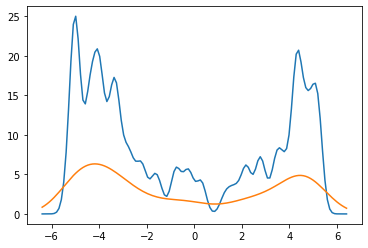

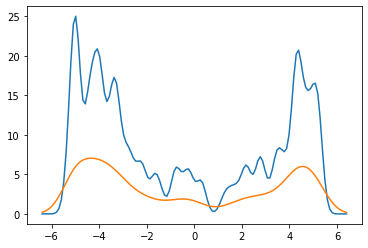

<Figure size 432x288 with 0 Axes>

In [5]:
x, y1, y2, y3, y4 = testDataGenFakeKernel()
plt.plot(x, y1)
plt.plot(x, y2)
fig = plt.figure()
plt.plot(x, y3)
plt.plot(x, y4)
fig = plt.figure()

Sigma has been changed slightly. FakeKernel output.

In [6]:
def generateData(size=500):
    print('Generating Data...')
    dataArr = []
    labelArr = []  
    for iev in range(size):
        x, y1, y2, y3, y4 = testDataGen()
        
        # real data
        x = y2
        dataArr.append(x)
        labelArr.append(1)
        
        # fake data: random
        x = y4
        dataArr.append(x)
        labelArr.append(0)
        
        x, y1, y2, y3, y4 = testDataGenFakeKernel()
        
        # real data
        x = y2
        dataArr.append(x)
        labelArr.append(1)
        
        # fake data: FakeKernel
        x = y4
        dataArr.append(x)
        labelArr.append(0)
        
    print("done")
    return(np.array(dataArr), np.array(labelArr))

Here I have appended to the dataArr the real data, the noise, and the fake kernel with the sigma change.

In [7]:
def trainModel(dimShape):
    #Sequential model
    model = Sequential([
        #Acurracy is achieved much faster with 4 input nodes.
        layers.Dense(units=4, activation='relu', input_shape=dimShape),
        layers.Dense(units=1, activation='sigmoid')
    ])
    model.summary()

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    return(model)

In [8]:
data, label = generateData(1000)

Generating Data...
done


In [9]:
model = trainModel(data.shape[1:])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 516       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


In [10]:
Nepochs = 200
#Fit will actually train the model.
# X: input of shape (141,2)
# Y: target catagorization, either 1 or 0. Shape (141,2) for consistancy with X
model.fit(
    x=np.array(data),
    y=np.array(label),
    epochs=Nepochs,
    shuffle=True,
    validation_split=0.1,
    use_multiprocessing=True,
    workers=25,
    verbose=0
)

2022-06-02 20:47:01.657283: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [11]:
# generate testing data
testData, testLabels = generateData(1000)

Generating Data...
done


In [12]:
predictions = model.predict(testData)

(-0.05, 1.05)

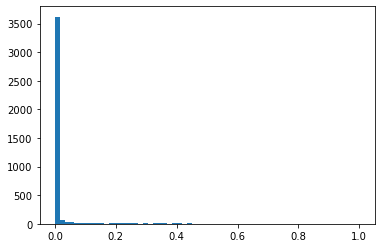

In [13]:
fig = plt.figure()
plt.hist(abs(predictions.reshape(4000) - testLabels), 50);
plt.xlim([-0.05, 1.05])

Save the model for loading later, if you would like to.

In [14]:
#model.save_weights('./model/save')

## Generator

In [15]:
def generator_model():
#    input = Input(shape=(100,)) #What does this do, exactly?

    model = Sequential([
        #First set of layers will be low resolution noise.
        layers.Dense(32*200, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        #Now we will reshape and upsample to get the final output dimension which should be (128,)
        layers.Reshape((32,200)),
        
        layers.Conv1DTranspose(64, 1, strides=2),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv1DTranspose(128, 1, strides=2),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv1DTranspose(1,1, activation="tanh")
    ])
    model.summary()

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    return(model)

In [16]:
gen = generator_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6400)              646400    
                                                                 
 batch_normalization (BatchN  (None, 6400)             25600     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6400)              0         
                                                                 
 reshape (Reshape)           (None, 32, 200)           0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 64, 64)           12864     
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64)          

In [22]:
noise = tf.random.normal([1,100])
generated_data = []

generated_data.append(np.array(tf.reshape(gen(noise, training=False), (128,))))
generated_data.append(np.array(tf.reshape(gen(noise, training=False), (128,))))
generated_data = np.array(generated_data)

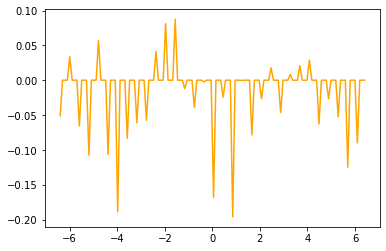

In [23]:
plt.plot(x, generated_data[0], color="orange")

What does the discriminator think?

[[0.5580501]
 [0.5580501]]


(-0.05, 1.05)

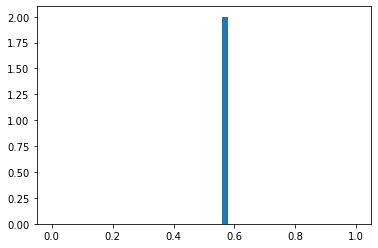

In [24]:
assert generated_data[0].shape == testData[0].shape
predictions = model.predict(generated_data)
print(predictions)
fig = plt.figure()
plt.hist(abs(predictions.reshape(2) - [0,0]), 50);
plt.xlim([-0.05, 1.05])